In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.path.append("..")
from src.utils import *
from scipy.stats import ttest_ind, permutation_test
from scipy import stats

In [2]:
# polars config
pl.Config.load_from_file("../polars_cfg.json")

In [ ]:
# data file paths
clean_summary_path = "../data/clean_summary_data_merged.csv"
clean_incomplete_path = "../data/clean_incomplete_data_merged.csv"
clean_all_path = "../data/clean_all_data_merged.csv"

In [3]:
# load / process data
df_summary = pl.read_csv(clean_summary_path)
df_incomplete = pl.read_csv(clean_incomplete_path)
df_all = pl.read_csv(clean_all_path)
df_all = df_all.with_columns(
    pl.col("time").map_elements(parse_mixed_datetime, return_dtype=pl.Datetime),
    pl.col("condition").cast(pl.Float64),
)
df_incomplete = df_incomplete.with_columns(
    pl.col("time").map_elements(parse_mixed_datetime, return_dtype=pl.Datetime),
    pl.col("condition").cast(pl.Float64),
)
columns = [
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "num_actions",
    "solved",
    "time",
    "condition",
    "test_input_grid",
    "test_output_grid",
    "exp_name",
]
df_all = pl.concat([df_all.select(columns), df_incomplete.select(columns)])
df_summary, df_incomplete_summary = include_incomplete(df_summary, df_incomplete)
# load task accuracy data
mean_task_acc = pl.read_csv("../data/mean_task_acc_three_attempts.csv")

Filtered out 59/783 incomplete participant task attempts


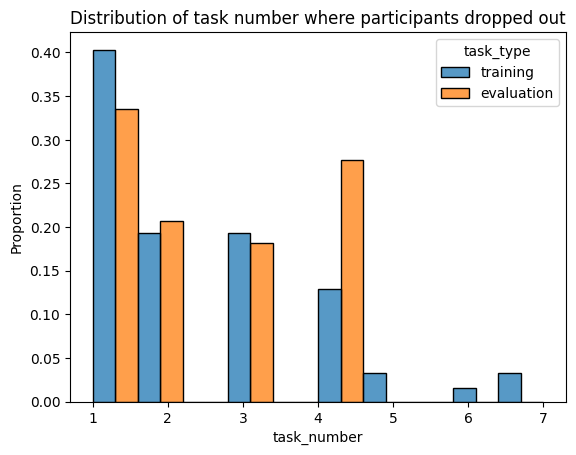

In [4]:
# plot distribution of task number where participants dropped out
sns.histplot(
    df_incomplete_summary.select(
        pl.all()
        .top_k_by("task_number", k=1)
        .over("hashed_id", mapping_strategy="explode")
    ),
    x="task_number",
    hue="task_type",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
)
plt.title("Distribution of task number where participants dropped out")
plt.show()

In [5]:
# for each task_type, compute how many drop after 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 attempts
# total_training =
dropout_after = (
    df_incomplete_summary.group_by("hashed_id")
    .agg(pl.max("task_number"), pl.first("task_type"))
    .group_by(["task_type", "task_number"])
    .agg(pl.len())
)
dropout_after.sort(["task_type", "task_number"])

task_type,task_number,len
str,i64,u32
"""evaluation""",1,81
"""evaluation""",2,50
"""evaluation""",3,44
"""evaluation""",4,67
"""training""",1,25
"""training""",2,12
"""training""",3,12
"""training""",4,8
"""training""",5,2


In [6]:
# dropout rates
training_incomplete = df_incomplete.filter(pl.col("task_type") == "training").n_unique(
    "hashed_id"
)
training_total = df_summary.filter(pl.col("task_type") == "training").n_unique(
    "hashed_id"
)
training_dropout_rate = training_incomplete / training_total

evaluation_incomplete = df_incomplete.filter(
    pl.col("task_type") == "evaluation"
).n_unique("hashed_id")
evaluation_total = df_summary.filter(pl.col("task_type") == "evaluation").n_unique(
    "hashed_id"
)
evaluation_dropout_rate = evaluation_incomplete / evaluation_total

print(
    f"Training dropout rate: {training_incomplete}/{training_total} ({training_dropout_rate:.3f}, {round(training_dropout_rate * 100, 1)}%)"
)
print(
    f"Evaluation dropout rate: {evaluation_incomplete}/{evaluation_total} ({evaluation_dropout_rate:.3f}, {round(evaluation_dropout_rate * 100, 1)}%)"
)

Training dropout rate: 90/783 (0.115, 11.5%)
Evaluation dropout rate: 242/946 (0.256, 25.6%)


In [10]:
# amount of missing data
df_summary_ten = df_summary.filter(pl.col("exp_name").is_in(["expv0", "expv1"]))
df_summary_five = df_summary.filter(~pl.col("exp_name").is_in(["expv0", "expv1"]))
total_expected_task_data = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.n_unique("hashed_id") * 5
)
total_expected_task_data_training = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.filter(pl.col("task_type") == "training").n_unique("hashed_id")
    * 5
)
total_expected_task_data_evaluation = (
    df_summary_five.filter(pl.col("task_type") == "evaluation").n_unique("hashed_id")
    * 5
)
observed_task_data = df_summary.n_unique("joint_id_task")
observed_task_data_training = df_summary.filter(
    pl.col("task_type") == "training"
).n_unique("joint_id_task")
observed_task_data_evaluation = df_summary.filter(
    pl.col("task_type") == "evaluation"
).n_unique("joint_id_task")
print(
    f"Proportion of task data missing: {round((1 - observed_task_data / total_expected_task_data) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on training set: {round((1 - observed_task_data_training / total_expected_task_data_training) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on evaluation set: {round((1 - observed_task_data_evaluation / total_expected_task_data_evaluation) * 100, 1)}%"
)

Proportion of task data missing: 10.3%
Proportion of task data expected on training set: 7.5%
Proportion of task data expected on evaluation set: 13.3%


In [ ]:
# amount of missing data
df_summary_ten = df_summary.filter(pl.col("exp_name").is_in(["expv0", "expv1"]))
df_summary_five = df_summary.filter(~pl.col("exp_name").is_in(["expv0", "expv1"]))
total_expected_task_data = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.n_unique("hashed_id") * 5
)
total_expected_task_data_training = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.filter(pl.col("task_type") == "training").n_unique("hashed_id")
    * 5
)
total_expected_task_data_evaluation = (
    df_summary_five.filter(pl.col("task_type") == "evaluation").n_unique("hashed_id")
    * 5
)
observed_task_data = df_summary.n_unique("joint_id_task")
observed_task_data_training = df_summary.filter(
    pl.col("task_type") == "training"
).n_unique("joint_id_task")
observed_task_data_evaluation = df_summary.filter(
    pl.col("task_type") == "evaluation"
).n_unique("joint_id_task")
print(
    f"Proportion of task data missing: {round((1 - observed_task_data / total_expected_task_data) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on training set: {round((1 - observed_task_data_training / total_expected_task_data_training) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on evaluation set: {round((1 - observed_task_data_evaluation / total_expected_task_data_evaluation) * 100, 1)}%"
)

Proportion of task data missing: 10.3%
Proportion of task data expected on training set: 7.5%
Proportion of task data expected on evaluation set: 13.3%


# let's focus on evaluation set incomplete data


In [7]:
# mean difficulty of tasks for participants that dropped out
mean_difficulty_dropout = (
    df_incomplete_summary.filter(pl.col("task_type") == "evaluation")
    .join(mean_task_acc, on="task_name")
    .select(
        pl.all()
        .top_k_by("attempt_number", k=1)
        .over("joint_id_task", mapping_strategy="explode")
    )
)
mean_difficulty_dropout = mean_difficulty_dropout.group_by("task_name").agg(
    pl.len().alias("n"), pl.first("mean_solved")
)
# compute average diff
subset_mean_diff = mean_difficulty_dropout.select(pl.mean("mean_solved")).item()

# computed weighted average of mean difficulty
subset_wmean_diff = (
    mean_difficulty_dropout.with_columns(
        weighted_mean_difficulty=(pl.col("mean_solved") * pl.col("n"))
    )
    .select(pl.sum("weighted_mean_difficulty") / pl.sum("n"))
    .item()
)
print(
    f"\tAverage difficulty of subset of tasks completed by dropout participants: {round(subset_mean_diff*100, 2)}"
)
print(
    f"\tWeighted average of difficulty of subset of tasks completed by dropout participants: {round(subset_wmean_diff*100, 2)}"
)
mean_difficulty_complete = (
    df_summary.filter(pl.col("task_type") == "evaluation")
    .join(mean_task_acc, on="task_name")
    .select(
        pl.all()
        .top_k_by("attempt_number", k=1)
        .over("joint_id_task", mapping_strategy="explode")
    )
)
mean_difficulty_complete = (
    mean_difficulty_complete.group_by("task_name")
    .agg(pl.len().alias("n"), pl.first("mean_solved"))
    .filter(~pl.col("task_name").is_in(mean_difficulty_dropout.select("task_name")))
)
complement_mean_diff = mean_difficulty_complete.select(pl.mean("mean_solved")).item()
complement_wmean_diff = (
    mean_difficulty_complete.with_columns(
        weighted_mean_difficulty=(pl.col("mean_solved") * pl.col("n"))
    )
    .select(pl.sum("weighted_mean_difficulty") / pl.sum("n"))
    .item()
)
print(
    "\nNow, excluding the tasks that were completed by participants that dropped out:\n"
)
print(
    f"\tAverage difficulty of subset of tasks done by participants that completed the study: {round(complement_mean_diff*100, 2)}"
)
print(
    f"\tWeighted average difficulty of subset of tasks done by participants that completed the study: {round(complement_wmean_diff*100, 2)}"
)

	Average difficulty of subset of tasks completed by dropout participants: 63.98
	Weighted average of difficulty of subset of tasks completed by dropout participants: 62.99

Now, excluding the tasks that were completed by participants that dropped out:

	Average difficulty of subset of tasks done by participants that completed the study: 64.78
	Weighted average difficulty of subset of tasks done by participants that completed the study: 64.65


In [8]:
# run statistical test to see if the difference is significant
mean_difficulty_complete_ = mean_difficulty_complete.select("mean_solved").to_numpy()
mean_difficulty_dropout_ = mean_difficulty_dropout.select("mean_solved").to_numpy()

t_stat, p_val = stats.ttest_ind(mean_difficulty_complete_, mean_difficulty_dropout_)
print(f"t-statistic: {t_stat[0]:.3f}")
print(f"p-value: {p_val[0]:.3f}")

t-statistic: 0.316
p-value: 0.753


In [9]:
mean_dropout_diff = (
    df_incomplete_summary.group_by("joint_id_task")
    .agg(pl.any("solved"), pl.first("task_name"))
    .group_by("task_name")
    .agg(pl.mean("solved").alias("mean_solved_dropout"))
)

In [10]:
combined_rates = mean_difficulty_dropout.join(mean_dropout_diff, on="task_name").sort(
    ["n", "mean_solved"], descending=True
)
combined_rates.head(10)

task_name,n,mean_solved,mean_solved_dropout
str,u32,f64,f64
"""575b1a71.json""",6,0.916667,0.833333
"""55059096.json""",6,0.888889,0.833333
"""639f5a19.json""",6,0.583333,0.666667
"""85b81ff1.json""",6,0.428571,0.333333
"""bc4146bd.json""",6,0.416667,0.166667
"""8719f442.json""",6,0.0,0.0
"""bd14c3bf.json""",5,0.625,0.8
"""13713586.json""",5,0.5,0.4
"""14754a24.json""",5,0.444444,0.6


<Axes: xlabel='mean_solved', ylabel='mean_solved_dropout'>

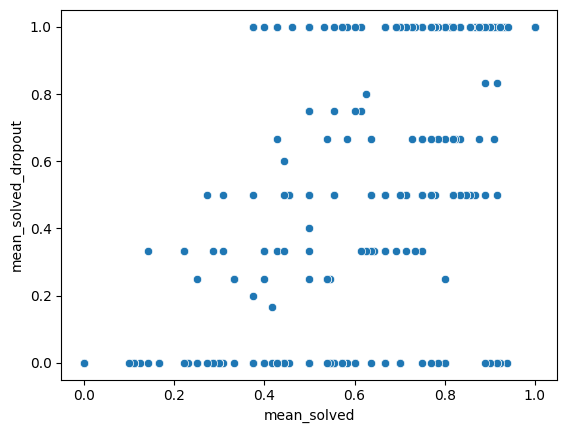

In [11]:
sns.scatterplot(
    data=combined_rates,
    x="mean_solved",
    y="mean_solved_dropout",
)

In [12]:
combined_rates.filter(
    (pl.col("mean_solved") > 0.6) & (pl.col("mean_solved_dropout") < 0.2)
)

task_name,n,mean_solved,mean_solved_dropout
str,u32,f64,f64
"""f21745ec.json""",2,0.75,0.0
"""7039b2d7.json""",2,0.666667,0.0
"""1990f7a8.json""",1,0.9375,0.0
"""00dbd492.json""",1,0.923077,0.0
"""1da012fc.json""",1,0.916667,0.0
"""8597cfd7.json""",1,0.916667,0.0
"""963f59bc.json""",1,0.9,0.0
"""c3202e5a.json""",1,0.888889,0.0
…,…,…,…


In [13]:
success_rate_dropouts = (
    (
        df_incomplete_summary.filter(pl.col("task_type") == "evaluation")
        .group_by("joint_id_task")
        .agg(pl.any("solved"), pl.first("hashed_id"))
    )
    .group_by("hashed_id")
    .agg(pl.mean("solved").alias("mean_success_rate"))
)
success_rate_complete = (
    (
        df_summary.filter(pl.col("task_type") == "evaluation")
        .group_by("joint_id_task")
        .agg(pl.any("solved"), pl.first("hashed_id"))
    )
    .group_by("hashed_id")
    .agg(pl.mean("solved").alias("mean_success_rate"))
)

In [14]:
# run statistical test to see if the difference is significant
success_rate_complete_ = success_rate_complete.select("mean_success_rate").to_numpy()
success_rate_dropouts_ = success_rate_dropouts.select("mean_success_rate").to_numpy()

t_stat, p_val = stats.ttest_ind(success_rate_complete_, success_rate_dropouts_)
print(f"t-statistic: {t_stat[0]:.3f}")
print(f"p-value: {p_val[0]:.3f}")

t-statistic: 4.045
p-value: 0.000


Ok so here we have a positive significant difference in success rate between participants that completed the experiment and those that dropped out.

This points to participants dropping out being less willing to put in effort / less capable of solving these problems.


In [15]:
# now, let's look at time spent on each problem as a proxy for effort

# first filter out incomplete tasks to avoid biasing the data
df_incomplete_filtered = df_incomplete.filter(
    (pl.col("task_type") == "evaluation")
    & pl.col("joint_id_task").is_in(df_incomplete_summary.select("joint_id_task"))
)
time_to_complete_dropout = (
    df_incomplete_filtered.group_by(["joint_id_task"])
    .agg(
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.col("task_name").first(),
        pl.col("hashed_id").first(),
        pl.any("solved"),
        pl.first("task_type"),
    )
    .with_columns((pl.col("max_time") - pl.col("min_time")).alias("time_to_complete"))
)
# cast time to complete to seconds
time_to_complete_dropout = time_to_complete_dropout.with_columns(
    pl.col("time_to_complete")
    .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
    .alias("seconds_to_complete")
)

time_to_complete_complete = (
    df_all.filter(pl.col("task_type") == "evaluation")
    .group_by(["joint_id_task"])
    .agg(
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.col("task_name").first(),
        pl.col("hashed_id").first(),
        pl.any("solved"),
        pl.first("task_type"),
    )
    .with_columns(
        (pl.col("max_time") - pl.col("min_time"))
        .alias("time_to_complete")
        .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
        .alias("seconds_to_complete")
    )
)

In [16]:
# run statistical test to see if the difference is significant
time_to_complete_complete_ = (
    time_to_complete_complete.select("seconds_to_complete")
    .filter(pl.col("seconds_to_complete").is_not_null())
    .to_numpy()
    .flatten()
)
print(
    f"Mean time per task for complete participants: {time_to_complete_complete_.mean()}"
)
time_to_complete_dropout_ = (
    time_to_complete_dropout.select("seconds_to_complete")
    .filter(pl.col("seconds_to_complete").is_not_null())
    .to_numpy()
    .flatten()
)
print(
    f"Mean time per task for dropout participants: {time_to_complete_dropout_.mean()}"
)
t_stat, p_val = stats.ttest_ind(time_to_complete_complete_, time_to_complete_dropout_)
print("\nIndependent t-test for time to complete tasks:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3f}")

Mean time per task for complete participants: 399.4842336836959
Mean time per task for dropout participants: 594.7986230636833

Independent t-test for time to complete tasks:
t-statistic: -11.564
p-value: 0.000


Unfortunately, the evidence gathered here points towards participants that dropped out finding it too hard.

Participants that dropout spend significantly more time on each problem on average than participants that complete the experiment yet their success rate is significantly lower. We also find that there is no significant difference in the difficulty of the tasks that participants that dropped out see compared to the other set of tasks.

I think we can safely conclude that these participants find the tasks harder or have trouble using the interface


In [24]:
# another thing to look at is time spent in other tabs by participants
time_unfocused = pl.read_csv("../../arc_project/data/unfocused_time_merged.csv")
time_unfocused.head()

hashed_id,unfocused_time,experiment
str,f64,str
"""0954867f72ce85860194b72a05f5d048""",54.52,"""pilot"""
"""64126f22f91fcbd7f341bf2c78bc9b5b""",3.494,"""pilot"""
"""d4623ca1932570dd40a9bb214c0d5fc4""",0.0,"""pilot"""
"""1afc71a45b1f137bbc9ce37124ae554e""",0.0,"""pilot"""
"""e7991fb1319e21785e67a474d48dae84""",48.28,"""pilot"""


In [25]:
time_to_complete_complete_exp = time_to_complete_complete.group_by("hashed_id").agg(
    pl.sum("seconds_to_complete")
)
time_to_complete_dropout_exp = time_to_complete_dropout.group_by("hashed_id").agg(
    pl.sum("seconds_to_complete")
)

time_unfocused_complete = time_unfocused.join(
    time_to_complete_complete_exp, on="hashed_id"
)
time_unfocused_complete = time_unfocused_complete.with_columns(
    pl.col("unfocused_time") / pl.col("seconds_to_complete")
).filter(pl.col("unfocused_time").is_not_null())

time_unfocused_dropout = time_unfocused.join(
    time_to_complete_dropout_exp, on="hashed_id"
)
time_unfocused_dropout = time_unfocused_dropout.with_columns(
    pl.col("unfocused_time") / pl.col("seconds_to_complete")
).filter(pl.col("unfocused_time").is_not_null())

In [26]:
time_unfocused_dropout_ = (
    time_unfocused_dropout.select("unfocused_time").to_numpy().flatten()
)
time_unfocused_complete_ = (
    time_unfocused_complete.select("unfocused_time").to_numpy().flatten()
)
# remove nans and infs
time_unfocused_dropout_ = time_unfocused_dropout_[~np.isnan(time_unfocused_dropout_)]
time_unfocused_dropout_ = time_unfocused_dropout_[~np.isinf(time_unfocused_dropout_)]
time_unfocused_complete_ = time_unfocused_complete_[~np.isnan(time_unfocused_complete_)]
time_unfocused_complete_ = time_unfocused_complete_[~np.isinf(time_unfocused_complete_)]

t_stat, p_val = stats.ttest_ind(time_unfocused_complete_, time_unfocused_dropout_)
print(
    f"Mean time spent in other tabs for complete participants: {time_unfocused_complete_.mean()}"
)
print(
    f"Mean time spent in other tabs for dropout participants: {time_unfocused_dropout_.mean()}"
)

print("\nIndependent t-test for time spent in other tabs:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3f}")

Mean time spent in other tabs for complete participants: 0.08297142526736385
Mean time spent in other tabs for dropout participants: 0.05042761057345751

Independent t-test for time spent in other tabs:
t-statistic: 1.248
p-value: 0.212
